# Check PSF correction in A360 field

Contact author: Céline Combet; with inputs of many during March 26 telecon (Anthony, Ian, Miranda, Shenming,...)\
LSST Science Piplines version: Weekly 2025_09\
Container Size: large

This notebook aims at check the PSF behaviour and correction in A360 field, that we use to perform the WL analysis. The main steps are

- Loading the relevant stars from the object catalogs (all tracts and patches needed) using the butler
- Checking out the size of the PSF accross the field
- Computing the ellipticities of stars and corresponding PSF model and make the whisker plots to check out the residuals. 

NB: All is done in x-y coordinates. We were puzzled how the radec selection of the stars in the fields translated into x-y (see 'Check location of PSF stars section below')

NB: Check out the [PSF DP0.2 tutorial](https://github.com/lsst/tutorial-notebooks/blob/main/DP0.2/12b_PSF_Science_Demo.ipynb) for more PSF diagnostics 

Rho statistics: Andrés A. Plazas Malagón, using `analysis_tools` and reserved stars [5/30/3035].

In [1]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.geom as afwGeom

In [3]:
repo = '/repo/main'
#collection = 'LSSTComCam/runs/DRP/DP1/w_2025_08/DM-49029'
#collection = 'LSSTComCam/runs/DRP/DP1/w_2025_09/DM-49235'
collection = 'LSSTComCam/runs/DRP/DP1/v29_0_0_rc5/DM-49865'
butler = Butler(repo, collections=collection)
skymap = butler.get('skyMap', skymap='lsst_cells_v1')

In [4]:
version_str = collection.split('/')
version = version_str[-2:][0]+'_'+version_str[-2:][1]
version

'v29_0_0_rc5_DM-49865'

## Load the relevant catalogs
For PSF studies, we need to look at stars
### Find all tracts/patches to load

In [5]:
# Position of the BCG for A360
ra_bcg = 37.862
dec_bcg = 6.98

# Looking for all patches in delta deg region around it
delta = 0.5
center = geom.SpherePoint(ra_bcg, dec_bcg, geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

ra_range = (ra_min, ra_max)
dec_range = (dec_min, dec_max)
radec = [geom.SpherePoint(ra_range[0], dec_range[0], geom.degrees),
         geom.SpherePoint(ra_range[0], dec_range[1], geom.degrees),
         geom.SpherePoint(ra_range[1], dec_range[0], geom.degrees),
         geom.SpherePoint(ra_range[1], dec_range[1], geom.degrees)]

tracts_and_patches = skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})
#tp_dict

### Load quantities with the cuts needed to get PSF stars, etc. 

In [6]:
# Get the object catlaog of these patches
if 'v29' in version:
    datasetType = 'object_patch'
else:
    datasetType = 'objectTable'
 
#datasetType = 'deepCoadd_obj'
merged_cat_reserved = pd.DataFrame()
merged_cat_used = pd.DataFrame()
merged_cat_all = pd.DataFrame()

for tract in tp_dict.keys():
    print(f'Loading objects from tract {tract}, patches:{tp_dict[tract]}')
    for patch in tp_dict[tract]:
#        print(patch)
        dataId = {'tract': tract, 'patch' : patch ,'skymap':'lsst_cells_v1'}
        obj_cat = butler.get(datasetType, dataId=dataId)
        if datasetType == 'object_patch': # new naming convention in v29_0_0_rc5, and obj_cat is now an astropy table. 
            obj_cat = obj_cat.to_pandas() # convert to pandas to leave the rest of the code unchanged

        # Stars used for the PSF modeling
        filt = obj_cat['detect_isPrimary'] == True
        filt &= obj_cat['refExtendedness'] == 0.0 # keep stars only
        filt &= obj_cat['i_calib_psf_used'] == True # that were used to build the psf model
        filt &= obj_cat['i_pixelFlags_inexact_psfCenter'] == False # To avoid objects with discontinuous PSF (due to edges)
        filt &= obj_cat['i_calibFlux'] > 360 # nJy, be bright
        merged_cat_used = pd.concat([merged_cat_used, obj_cat[filt]], ignore_index=True)

        # Stars "reserved" to check the PSF modeling
        filt = obj_cat['detect_isPrimary'] == True
        filt &= obj_cat['refExtendedness'] == 0.0
        filt &= obj_cat['i_calib_psf_reserved'] == True # not used for the psf model
        filt &= obj_cat['i_pixelFlags_inexact_psfCenter']==False
        merged_cat_reserved = pd.concat([merged_cat_reserved, obj_cat[filt]], ignore_index=True)

        # All extended objects (to have more locations where to look at the PSF model)
        filt = obj_cat['detect_isPrimary']==True
        filt &= obj_cat['refExtendedness'] == 1.0
        merged_cat_all = pd.concat([merged_cat_all, obj_cat[filt]], ignore_index=True)
        

Loading objects from tract 10463, patches:[30, 40, 50, 60, 70, 80, 90, 31, 41, 51, 61, 71, 81, 91, 32, 42, 52, 62, 72, 82, 92, 33, 43, 53, 63, 73, 83, 93, 34, 44, 54, 64, 74, 84, 94]
Loading objects from tract 10704, patches:[0, 1, 2, 3, 4, 5]
Loading objects from tract 10464, patches:[37, 47, 57, 67, 77, 87, 97, 38, 48, 58, 68, 78, 88, 98, 39, 49, 59, 69, 79, 89, 99]
Loading objects from tract 10705, patches:[8, 9]


### Check out the location of the PSF stars, in (ra, dec) and (x,y) coordinates, colored by track number - Reason for the pattern/gap in (x,y)?

The BCG and 0.5 deg field are highlighted in the (ra,dec) plot

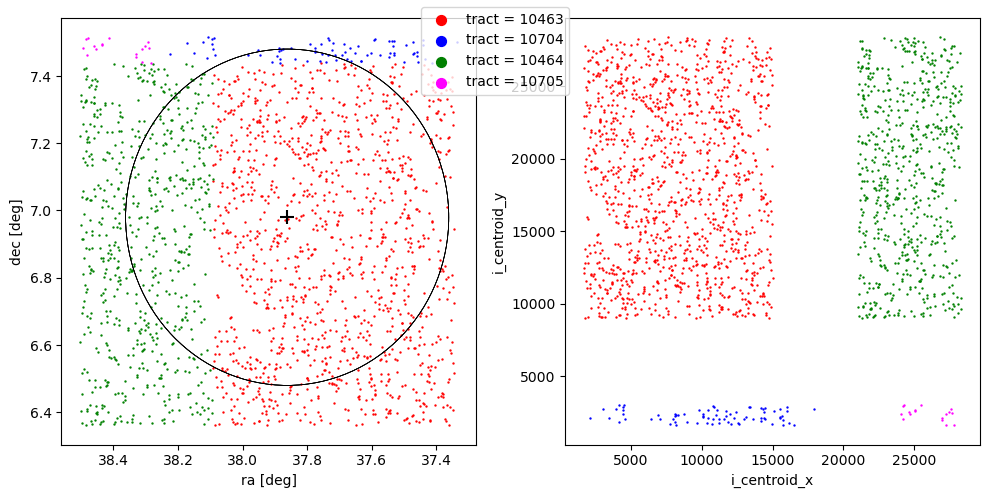

In [13]:
from matplotlib.patches import Circle

circle1 = Circle((ra_bcg, dec_bcg), 0.5, color='black', fill=False, linewidth=0.5)

color = ['red', 'blue','green','magenta']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for i,tract in enumerate(list(tp_dict.keys())):
    filt = merged_cat_used['tract'] == tract
    ax[0].scatter(merged_cat_used[filt]['coord_ra'], merged_cat_used[filt]['coord_dec'], 
                  c=color[i],  marker='.', s=2, label=f'tract = {tract}')    
    ax[0].set_xlabel('ra [deg]')
    ax[0].set_ylabel('dec [deg]')
    ax[0].add_patch(circle1)

for i,tract in enumerate(list(tp_dict.keys())):
    filt = merged_cat_used['tract'] == tract
    ax[1].scatter(merged_cat_used[filt]['i_centroid_x'], merged_cat_used[filt]['i_centroid_y'],  marker='.', s=2, c=color[i])
ax[1].set_xlabel('i_centroid_x')
ax[1].set_ylabel('i_centroid_y')
fig.tight_layout()

ax[0].scatter([ra_bcg], [dec_bcg], marker='+', s=100, c='black')
ax[0].invert_xaxis()

fig.legend(loc=9, markerscale=10)

In (ra,dec), the stars cover the field and we can see which tract contribute to which area. In (x,y), we see a clear gap between the tracts. We do not understand where this is coming from (need to ask DM folks), but we can nontheless move on with the PSF charracterisation in the field.

## PSF size variation across the field

The `i_i{xx,xy,yy}PSF` quantities are the second moment of the PSF model for each object location in the catalog. The trace radius (PSF size) of the PSF is defined as
$r_t = \sqrt{(I_{xx} + I_{yy}/2)}$

We look at the size of the PSF:
- at the location of `used` stars (`merged_cat_used` catalog)
- at the location of all extended objects (`merged_cat_all` catalog), to have a better coverage of the field and visualize PSF discontinutities, etc.


In [14]:
size = np.sqrt((merged_cat_used['i_ixxPSF'] + merged_cat_used['i_iyyPSF']) / 2)
size_all = np.sqrt((merged_cat_all['i_ixxPSF'] + merged_cat_all['i_iyyPSF']) / 2) # at all extended objects locations

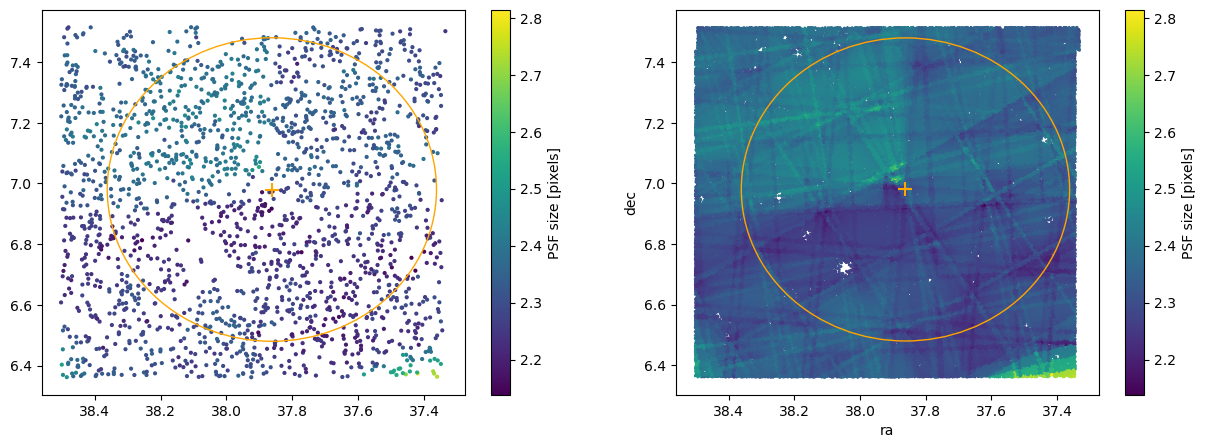

In [15]:
from matplotlib.patches import Circle

ra, dec =  merged_cat_used['coord_ra'], merged_cat_used['coord_dec']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

scatter_plot1 = ax[0].scatter(ra, dec, c=size, s=4, cmap='viridis', marker='o')
circle1 = Circle((ra_bcg, dec_bcg), 0.5, color='orange', fill=False, linewidth=1, 
                label='0.5 deg field around BCG')

ax[0].scatter([ra_bcg], [dec_bcg], marker='+', s=100, c='orange')
ax[0].invert_xaxis()
ax[0].add_patch(circle1)
#ax.add_patch(circle2)

scatter_plot2 = ax[1].scatter(merged_cat_all['coord_ra'], merged_cat_all['coord_dec'], 
                              c=size_all, s=1, cmap='viridis', marker='o')
ax[1].set_xlabel('ra')
ax[1].set_ylabel('dec')
ax[1].scatter([ra_bcg], [dec_bcg], marker='+', s=100, c='orange')
circle2 = Circle((ra_bcg, dec_bcg), 0.5, color='orange', fill=False, linewidth=1, 
                label='0.5 deg field around BCG')
ax[1].invert_xaxis()
ax[1].add_patch(circle2)

plt.colorbar(scatter_plot1, ax=ax[0], label='PSF size [pixels]')
plt.colorbar(scatter_plot1, ax=ax[1], label='PSF size [pixels]')

The PSF size is varying by ~0.5 pixel across A360 field. The figure on the right, showing the PSF size at more 
locations that highlight the discontinuities in the PSF modeling when close to edges. Also allows us to see the various orientation of visits used to build the coadd.

## Whisker plots - PSF ellipticity and PSF correction.

The ellipticity components $e_1$, $e_2$ are computed from moments as:

$e_1 = (I_{xx} - I_{yy}) / (I_{xx} + I_{yy})$

$e_2 = 2I_{xy} / (I_{xx} + I_{yy})$

The from this, the amplitude and orientation of the ellipse (angle of the ellipse major axis with respect to the (x,y) coordinate frame) are given by

$e = \sqrt{e_1^2 + e_2^2}$

$\theta = 0.5 \times \arctan (e_2/e_1)$

In [16]:
def get_psf_ellip(catalog):
    psf_mxx = catalog['i_ixxPSF']
    psf_myy = catalog['i_iyyPSF']
    psf_mxy = catalog['i_ixyPSF']
    return (psf_mxx - psf_myy) / (psf_mxx + psf_myy), 2.* psf_mxy / (psf_mxx + psf_myy)


def get_star_ellip(catalog):
    star_mxx = catalog['i_ixx']
    star_myy = catalog['i_iyy']
    star_mxy = catalog['i_ixy']
    return (star_mxx - star_myy) / (star_mxx + star_myy), 2. * star_mxy / (star_mxx + star_myy)

    

### Whisker plot and residuals at the locations of `used` stars

In [17]:
# For the PSF model, at the location of `used` stars
e1_psf_used, e2_psf_used = get_psf_ellip(merged_cat_used)
e_psf_used = np.sqrt(e1_psf_used*e1_psf_used + e2_psf_used*e2_psf_used) # module of ellipticity
theta_psf_used = 0.5 * np.arctan(e2_psf_used/e1_psf_used) # orientation

cx_psf_used = e_psf_used * np.cos(theta_psf_used) # x-component of the vector for the whisker plot
cy_psf_used = e_psf_used * np.sin(theta_psf_used) # y-component of the vector for the whisker plot

In [18]:
# Repeat for the `used` stars
e1_star_used, e2_star_used = get_star_ellip(merged_cat_used)
e_star_used = np.sqrt(e1_star_used*e1_star_used+e2_star_used*e2_star_used)
theta_star_used = 0.5 * np.arctan(e2_star_used/e1_star_used)

cx_star_used = e_star_used * np.cos(theta_star_used)
cy_star_used = e_star_used * np.sin(theta_star_used)

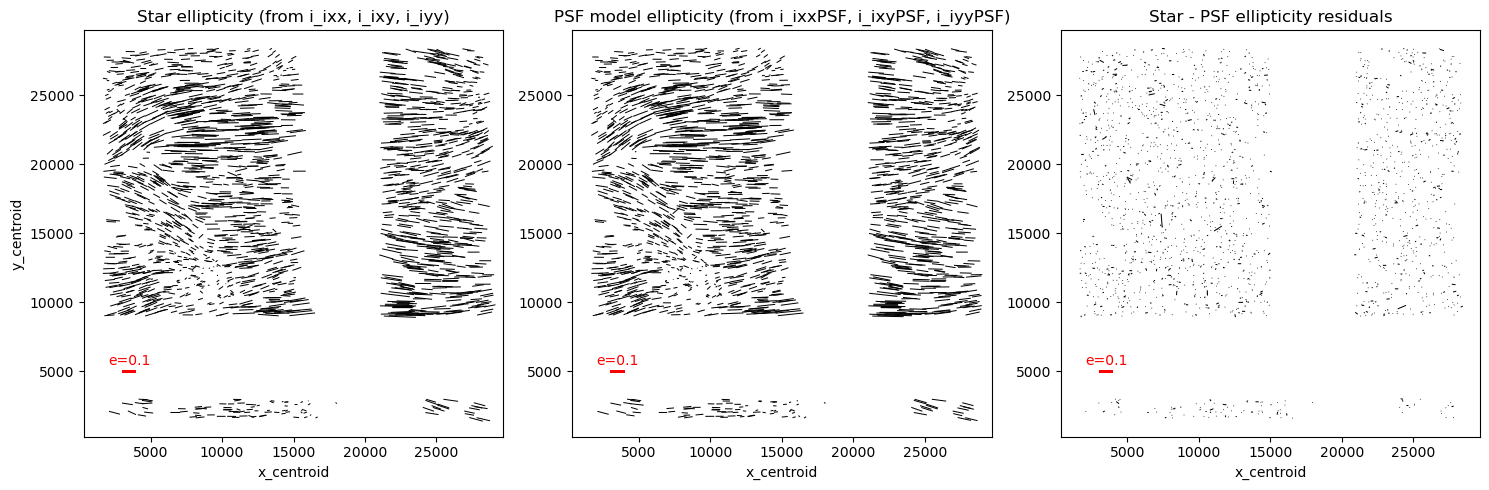

In [19]:
x_centroid, y_centroid =  merged_cat_used['i_centroid_x'], merged_cat_used['i_centroid_y']

scale = 10000

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].quiver(x_centroid, y_centroid, scale*cx_star_used, scale*cy_star_used, angles='xy', color='black',
           scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
         label='Star ellipticity')
ax[0].set_title('Star ellipticity (from i_ixx, i_ixy, i_iyy)')
ax[0].set_xlabel('x_centroid')
ax[0].set_ylabel('y_centroid')

ax[1].quiver(x_centroid, y_centroid, scale*cx_psf_used, scale*cy_psf_used, angles='xy', color='black',
           scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
         label='PSF model ellipticity')
ax[1].set_xlabel('x_centroid')
ax[1].set_title('PSF model ellipticity (from i_ixxPSF, i_ixyPSF, i_iyyPSF)')

ax[2].quiver(x_centroid, y_centroid, scale*(cx_star_used-cx_psf_used), scale*(cy_star_used-cy_psf_used), angles='xy', color='black',
           scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0)

ax[2].set_xlabel('x_centroid')
ax[2].set_title('Star - PSF ellipticity residuals')

ref_norm = scale*0.1  # Define reference vector norm
ref_x, ref_y = 3000, 5000  # Position to place reference vector
ax[0].quiver(ref_x, ref_y, ref_norm, 0, angles='xy', color='red',
             scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
             label=f'Ref: {ref_norm}')
ax[1].quiver(ref_x, ref_y, ref_norm, 0, angles='xy', color='red',
             scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
             label=f'Ref: {ref_norm}')
ax[2].quiver(ref_x, ref_y, ref_norm, 0, angles='xy', color='red',
             scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
             label=f'Ref: {ref_norm}')

ax[0].text(ref_x + ref_norm / 2, ref_y + 500, f'e=0.1', color='red', ha='center')
ax[1].text(ref_x + ref_norm / 2, ref_y + 500, f'e=0.1', color='red', ha='center')
ax[2].text(ref_x + ref_norm / 2, ref_y + 500, f'e=0.1', color='red', ha='center')

# 
fig.tight_layout()


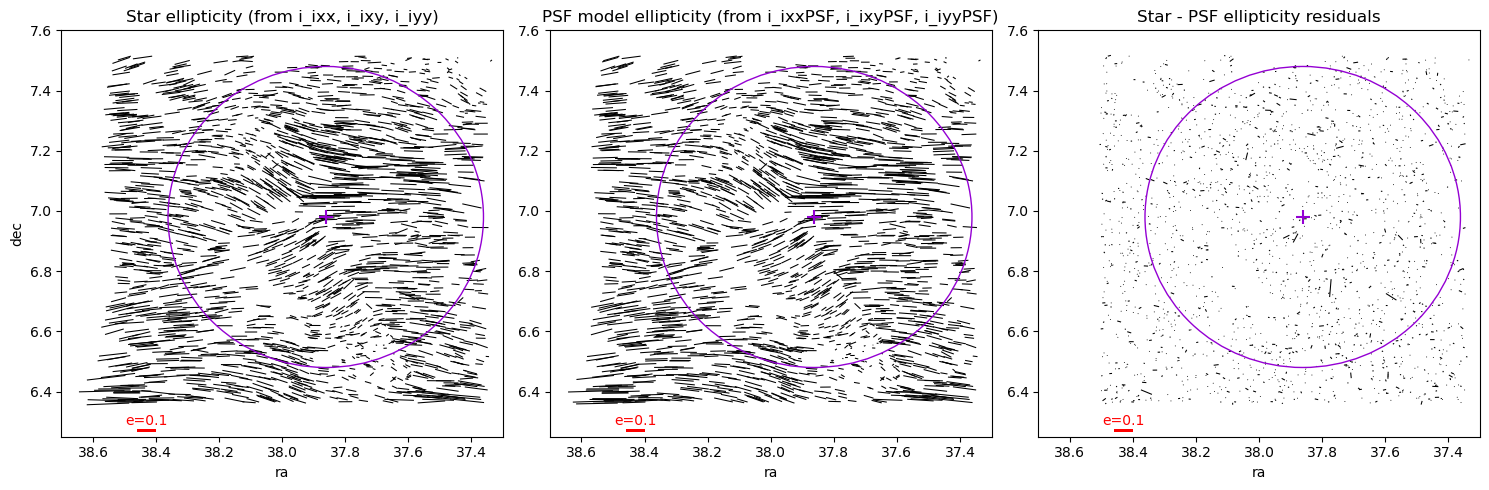

In [20]:
x_centroid, y_centroid =  merged_cat_used['coord_ra'], merged_cat_used['coord_dec']

scale = 0.6


circle0 = Circle((ra_bcg, dec_bcg), 0.5, color='darkviolet', fill=False, linewidth=1, 
                label='0.5 deg field around BCG')
circle1 = Circle((ra_bcg, dec_bcg), 0.5, color='darkviolet', fill=False, linewidth=1, 
                label='0.5 deg field around BCG')
circle2 = Circle((ra_bcg, dec_bcg), 0.5, color='darkviolet', fill=False, linewidth=1, 
                label='0.5 deg field around BCG')


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].quiver(x_centroid, y_centroid, scale*cx_star_used, scale*cy_star_used, angles='xy', color='black',
           scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
         label='Star ellipticity')
ax[0].scatter([ra_bcg], [dec_bcg], marker='+', s=100, c='darkviolet')
ax[0].add_patch(circle0)

ax[0].invert_xaxis()
ax[0].set_title('Star ellipticity (from i_ixx, i_ixy, i_iyy)')
ax[0].set_xlabel('ra')
ax[0].set_ylabel('dec')
ax[0].set_xlim([38.7, 37.3])
ax[0].set_ylim([6.25, 7.6])

ax[1].quiver(x_centroid, y_centroid, scale*cx_psf_used, scale*cy_psf_used, angles='xy', color='black',
           scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
         label='PSF model ellipticity')
ax[1].scatter([ra_bcg], [dec_bcg], marker='+', s=100, c='darkviolet')
ax[1].add_patch(circle1)

ax[1].invert_xaxis()
ax[1].set_xlabel('ra')
ax[1].set_title('PSF model ellipticity (from i_ixxPSF, i_ixyPSF, i_iyyPSF)')
ax[1].set_xlim([38.7, 37.3])
ax[1].set_ylim([6.25, 7.6])

ax[2].quiver(x_centroid, y_centroid, scale*(cx_star_used-cx_psf_used), scale*(cy_star_used-cy_psf_used), angles='xy', color='black',
           scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0)
ax[2].scatter([ra_bcg], [dec_bcg], marker='+', s=100, c='darkviolet')
ax[2].add_patch(circle2)

ax[2].invert_xaxis()
ax[2].set_xlabel('ra')
ax[2].set_title('Star - PSF ellipticity residuals')
ax[2].set_xlim([38.7, 37.3])
ax[2].set_ylim([6.25, 7.6])

ref_norm = scale*0.1  # Define reference vector norm
ref_x, ref_y = 38.4, 6.27  # Position to place reference vector
ax[0].quiver(ref_x, ref_y, ref_norm, 0, angles='xy', color='red',
             scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
             label=f'Ref: {ref_norm}')
ax[1].quiver(ref_x, ref_y, ref_norm, 0, angles='xy', color='red',
             scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
             label=f'Ref: {ref_norm}')
ax[2].quiver(ref_x, ref_y, ref_norm, 0, angles='xy', color='red',
             scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
             label=f'Ref: {ref_norm}')

ax[0].text(ref_x + ref_norm / 2, ref_y + 0.02, f'e=0.1', color='red', ha='center')
ax[1].text(ref_x + ref_norm / 2, ref_y + 0.02, f'e=0.1', color='red', ha='center')
ax[2].text(ref_x + ref_norm / 2, ref_y + 0.02, f'e=0.1', color='red', ha='center')


# ax[1].scatter([ra_bcg], [dec_bcg], marker='+', s=100, c='orange')
# ax[1].add_patch(circle1)
# ax[2].scatter([ra_bcg], [dec_bcg], marker='+', s=100, c='orange')
# ax[2].add_patch(circle1)
# 
fig.tight_layout()


(array([ 15.,  37.,  50.,  77.,  94., 115., 136., 236., 245., 220., 158.,
        149., 120.,  98.,  60.,  45.,  29.,  30.,  10.,  17.,   6.,   7.,
          7.,   2.,   4.,   1.,   0.,   0.,   1.,   1.]),
 array([0.00508943, 0.01293713, 0.02078483, 0.02863252, 0.03648021,
        0.04432791, 0.0521756 , 0.0600233 , 0.067871  , 0.07571869,
        0.08356639, 0.09141409, 0.09926178, 0.10710947, 0.11495717,
        0.12280487, 0.13065256, 0.13850026, 0.14634795, 0.15419565,
        0.16204335, 0.16989104, 0.17773874, 0.18558644, 0.19343412,
        0.20128182, 0.20912951, 0.21697721, 0.22482491, 0.2326726 ,
        0.24052031]),
 <BarContainer object of 30 artists>)

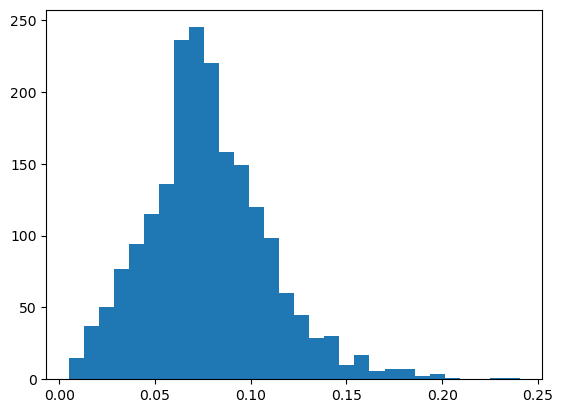

In [21]:
plt.hist(e_star_used, bins=30)

### Whisker plot and residuals at the locations of `reserved` stars (that haven't been used by PIFF)

Now we repeat the same thing with the `reserved` stars, that were not used to buid the PSF model. NB: there are far less reserved stars than PSF stars.

<bound method Figure.tight_layout of <Figure size 1500x500 with 3 Axes>>

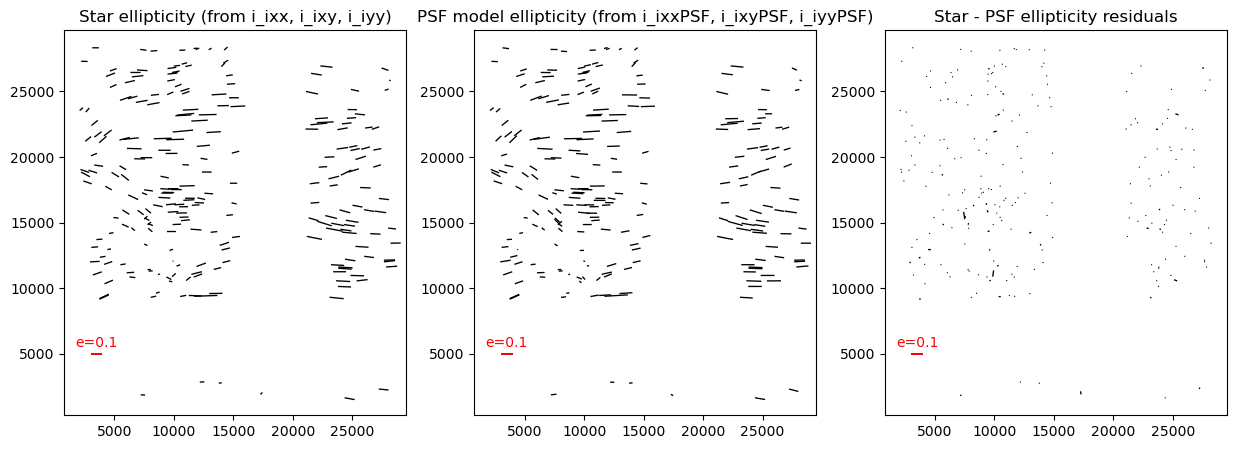

In [22]:
e1_psf_reserved, e2_psf_reserved = get_psf_ellip(merged_cat_reserved)
e_psf_reserved = np.sqrt(e1_psf_reserved*e1_psf_reserved+e2_psf_reserved*e2_psf_reserved)
theta_psf_reserved = 0.5 * np.arctan(e2_psf_reserved/e1_psf_reserved)
cx_psf_reserved = e_psf_reserved * np.cos(theta_psf_reserved) # x-component of the vector for the whisker plot
cy_psf_reserved = e_psf_reserved * np.sin(theta_psf_reserved) # y-component of the vector for the whisker plot


e1_star_reserved, e2_star_reserved = get_star_ellip(merged_cat_reserved)
e_star_reserved = np.sqrt(e1_star_reserved*e1_star_reserved+e2_star_reserved*e2_star_reserved)
theta_star_reserved = 0.5 * np.arctan(e2_star_reserved/e1_star_reserved)
cx_star_reserved = e_star_reserved * np.cos(theta_star_reserved) # x-component of the vector for the whisker plot
cy_star_reserved = e_star_reserved * np.sin(theta_star_reserved) # y-component of the vector for the whisker plot

x_centroid, y_centroid =  merged_cat_reserved['i_centroid_x'], merged_cat_reserved['i_centroid_y']

scale = 10000

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].quiver(x_centroid, y_centroid, scale*cx_star_reserved, scale*cy_star_reserved, angles='xy', color='black',
           scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
         label='PSF ellipticity')
ax[0].set_title('Star ellipticity (from i_ixx, i_ixy, i_iyy)')

ax[1].quiver(x_centroid, y_centroid, scale*cx_psf_reserved, scale*cy_psf_reserved, angles='xy', color='black',
           scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
         label='PSF ellipticity')
ax[1].set_title('PSF model ellipticity (from i_ixxPSF, i_ixyPSF, i_iyyPSF)')

ax[2].quiver(x_centroid, y_centroid, scale*(cx_star_reserved-cx_psf_reserved), scale*(cy_star_reserved-cy_psf_reserved), angles='xy', color='black',
           scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0)

ax[2].set_title('Star - PSF ellipticity residuals')

ref_norm = scale*0.1  # Define reference vector norm
ref_x, ref_y = 3000, 5000  # Position to place reference vector
ax[0].quiver(ref_x, ref_y, ref_norm, 0, angles='xy', color='red',
             scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
             label=f'Ref: {ref_norm}')
ax[1].quiver(ref_x, ref_y, ref_norm, 0, angles='xy', color='red',
             scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
             label=f'Ref: {ref_norm}')
ax[2].quiver(ref_x, ref_y, ref_norm, 0, angles='xy', color='red',
             scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
             label=f'Ref: {ref_norm}')

ax[0].text(ref_x + ref_norm / 2, ref_y + 500, f'e=0.1', color='red', ha='center')
ax[1].text(ref_x + ref_norm / 2, ref_y + 500, f'e=0.1', color='red', ha='center')
ax[2].text(ref_x + ref_norm / 2, ref_y + 500, f'e=0.1', color='red', ha='center')

fig.tight_layout


## Histogram of the e1, e2 residuals in A360 field, for `used` and `reserved` stars

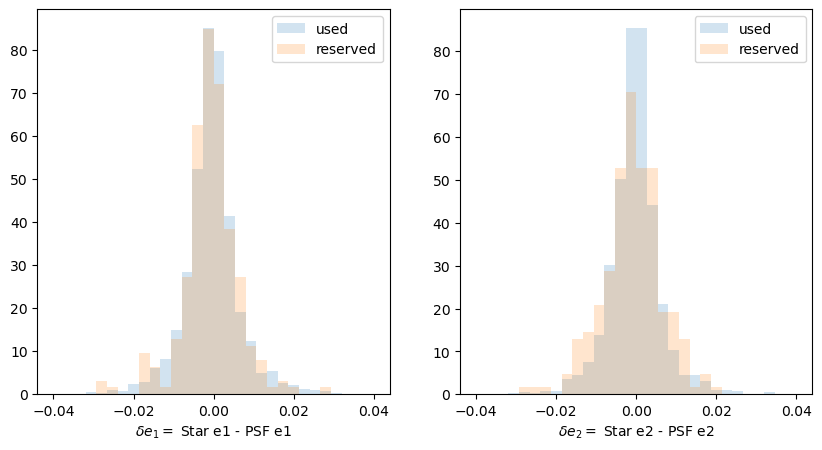

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax[0].hist((e1_star_used-e1_psf_used), bins=30, range=[-0.04, 0.04], density=True, alpha=0.2, label='used');
ax[0].hist((e1_star_reserved-e1_psf_reserved), bins=30, range=[-0.04, 0.04], density=True, alpha=0.2, label='reserved')
ax[0].set_xlabel(r'$\delta e_1 = $ Star e1 - PSF e1')
ax[0].legend()

ax[1].hist((e2_star_used-e2_psf_used), bins=30, range=[-0.04, 0.04], density=True, alpha=0.2, label='used');
ax[1].hist((e2_star_reserved-e2_psf_reserved), bins=30, range=[-0.04, 0.04], density=True, alpha=0.2, label='reserved')
ax[1].set_xlabel(r'$\delta e_2 = $ Star e2 - PSF e2')
ax[1].legend()

In [24]:
e1_hsm_star_used, e2_hsm_star_used = merged_cat_used['i_hsmShapeRegauss_e1'], merged_cat_used['i_hsmShapeRegauss_e2']
e_hsm_star_used = np.sqrt(e1_hsm_star_used*e1_hsm_star_used + e2_hsm_star_used*e2_hsm_star_used)
theta_hsm_star_used = 0.5 * np.arctan(e2_hsm_star_used/e1_hsm_star_used)

cx_hsm_star_used = e_hsm_star_used * np.cos(theta_hsm_star_used)
cy_hsm_star_used = e_hsm_star_used * np.sin(theta_hsm_star_used)

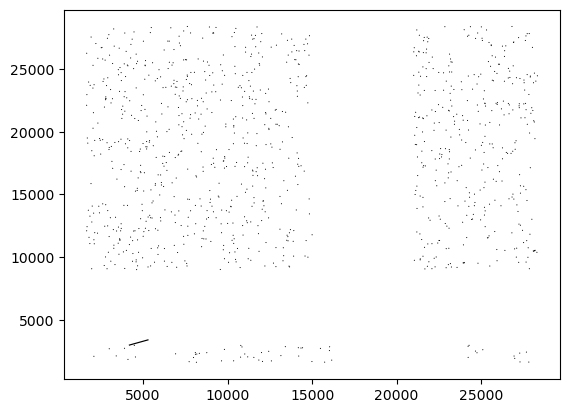

In [25]:
x_centroid, y_centroid =  merged_cat_used['i_centroid_x'], merged_cat_used['i_centroid_y']

plt.quiver(x_centroid, y_centroid, cx_hsm_star_used, cy_hsm_star_used , angles='xy', color='black',
           scale_units='xy', scale=1, headlength=0, headwidth=0, headaxislength=0,
         label='PSF ellipticity')

(array([ 5.,  2.,  7., 10., 16., 10., 19., 15., 32., 37., 43., 58., 56.,
        82., 60., 74., 61., 59., 48., 31., 34., 21., 20., 16., 11.,  7.,
         8.,  7.,  8.,  7.]),
 array([-1.        , -0.93333334, -0.86666667, -0.80000001, -0.73333335,
        -0.66666669, -0.60000002, -0.53333336, -0.46666667, -0.40000001,
        -0.33333334, -0.26666668, -0.2       , -0.13333334, -0.06666667,
         0.        ,  0.06666667,  0.13333334,  0.2       ,  0.26666668,
         0.33333334,  0.40000001,  0.46666667,  0.53333336,  0.60000002,
         0.66666669,  0.73333335,  0.80000001,  0.86666667,  0.93333334,
         1.        ]),
 <BarContainer object of 30 artists>)

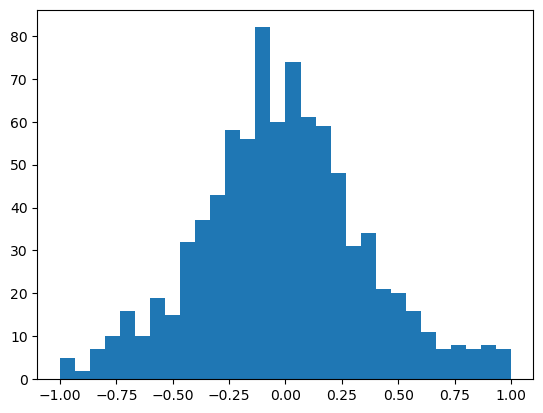

In [26]:
#filt = merged_cat_used['i_hsmShapeRegauss_flag'] == 0
plt.hist(e1_hsm_star_used, bins=30, range=[-1,1])


(array([ 0.        ,  0.        ,  0.02538072,  0.02538072,  0.02538072,
         0.17766501,  0.58375603,  1.04060935,  2.20812147,  5.27918892,
         8.1979682 , 12.36040637, 10.30456876,  5.98984785,  3.14720819,
         0.58375636,  0.05076142,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([-0.30000001, -0.28      , -0.25999999, -0.23999999, -0.22      ,
        -0.2       , -0.18000001, -0.16      , -0.14      , -0.12      ,
        -0.1       , -0.08      , -0.06      , -0.04      , -0.02      ,
         0.        ,  0.02      ,  0.04      ,  0.06      ,  0.08      ,
         0.1       ,  0.12      ,  0.14      ,  0.16      ,  0.18000001,
         0.2       ,  0.22      ,  0.23999999,  0.25999999,  0.28      ,
         0.30000001]),
 <BarContainer object of 30 artists>)

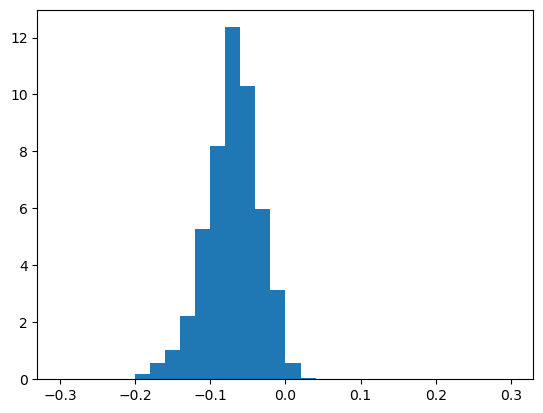

In [27]:
plt.hist(e1_star_used, bins=30, range=[-0.3,0.3], density = True)

In [30]:
from lsst.analysis.tools.atools import RhoStatistics

# Rho Statistics with analysis tools


In [43]:
atool = RhoStatistics()

In [44]:
atool.process.calculateActions.rho.treecorr.nbins = 21
atool.process.calculateActions.rho.treecorr.min_sep = 0.1
atool.process.calculateActions.rho.treecorr.max_sep = 100.0

In [45]:
atool.finalize()

In [46]:
input_schema = atool.getInputSchema()
needed_catalog_fields = [name[0] for name in list(atool.getInputSchema())]
print(needed_catalog_fields)

['coord_dec', 'coord_ra', '{band}_ixx', '{band}_ixxPSF', '{band}_ixy', '{band}_ixyPSF', '{band}_iyy', '{band}_iyyPSF', '{band}_psfFlux_flag', '{band}_pixelFlags_saturatedCenter', '{band}_extendedness_flag', 'xy_flag', 'sky_object', 'detect_isPatchInner', 'detect_isDeblendedSource', '{band}_psfFlux', '{band}_psfFluxErr', '{band}_extendedness']


In [47]:
my_band = "i"

In [49]:
len(merged_cat_reserved)

234

In [48]:
prepResults = atool.prep(merged_cat_reserved, band=f"{my_band}")

In [50]:
processResults = atool.process(prepResults, band=f"{my_band}")

In [51]:
print("Mean angular separation:\n", processResults['rho1'].meanr, "\n")
print("Correlation function:\n", processResults['rho1'].xip, "\n")
print("Error in the correlation function:\n", processResults['rho1'].varxip)

Mean angular separation:
 [ 0.11787686  0.14946617  0.22758459  0.33077913  0.45947041  0.67174079
  0.90412148  1.20719881  1.68607106  2.32062767  3.21394752  4.46501634
  6.20607713  8.67323515 12.07013465 16.64290962 23.08409441 32.05329963
 44.16392346 59.04367745 76.25827596] 

Correlation function:
 [ 0.00000000e+00  7.34649887e-07  0.00000000e+00  3.83522535e-06
  1.30849148e-05  7.01930008e-07  1.70057649e-06 -3.59652125e-06
  4.13867122e-06  6.42763643e-06  2.25898381e-06  1.68486001e-06
  1.60420788e-06  4.38785368e-07  3.03839228e-08  3.19135770e-07
  4.98343828e-07  3.30089242e-07 -3.37602870e-08  2.78451630e-07
 -1.06450529e-06] 

Error in the correlation function:
 [0.00000000e+00 3.37142786e-10 0.00000000e+00 1.12380929e-10
 6.74285572e-11 1.12380929e-10 3.74603096e-11 2.24761857e-11
 9.36507739e-12 4.43608929e-12 2.88156227e-12 1.37049913e-12
 7.36119620e-13 4.24078976e-13 2.34289636e-13 1.39372793e-13
 8.44334550e-14 5.79781231e-14 4.70344288e-14 7.74328861e-14
 1.091

In [55]:
atool.produce.plot.rhoPlots["rho3"].yLinThresh = 1e-8

In [56]:
plt.rcParams['figure.figsize'] = (2, 2)
plt.rcParams['lines.markersize'] = 2
plt.rcParams['xtick.labelsize']=5
plt.rcParams['ytick.labelsize']=5
plt.rcParams['font.size']=5

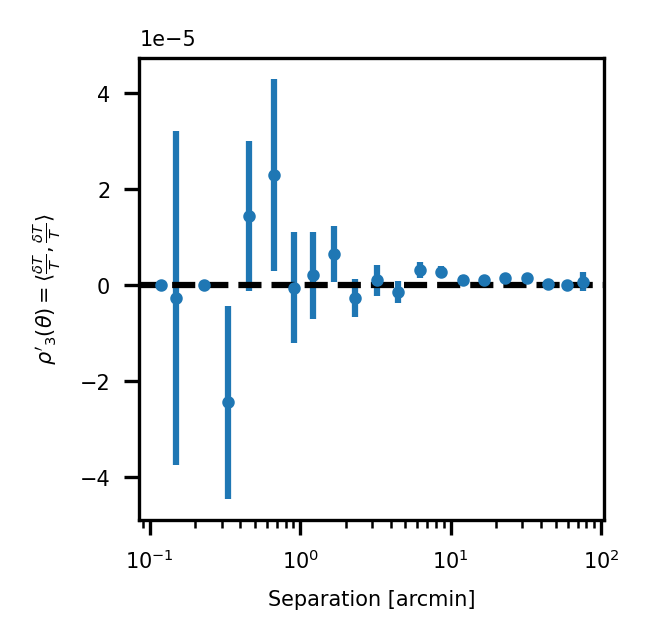

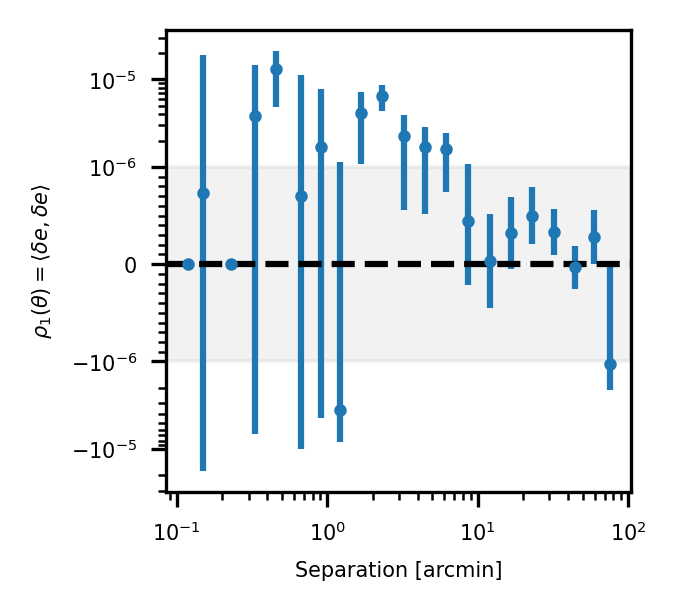

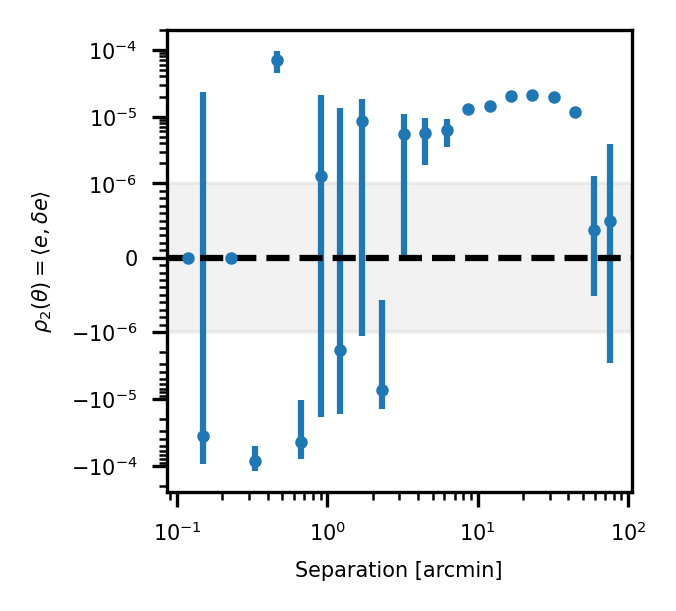

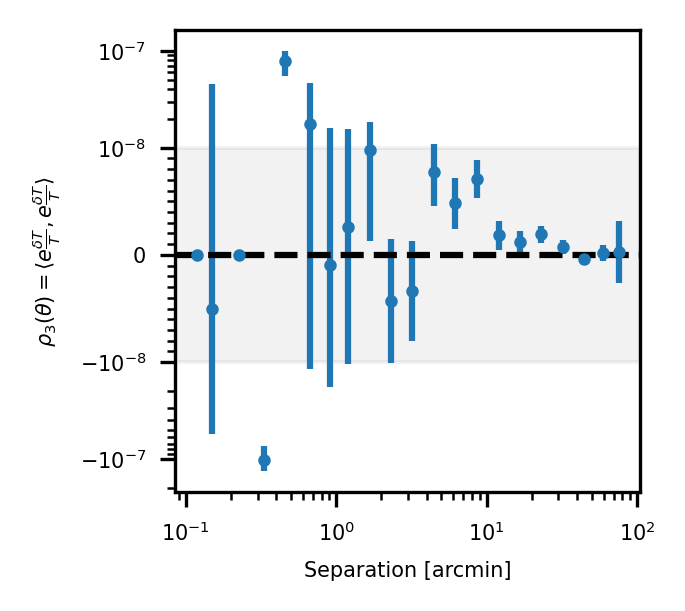

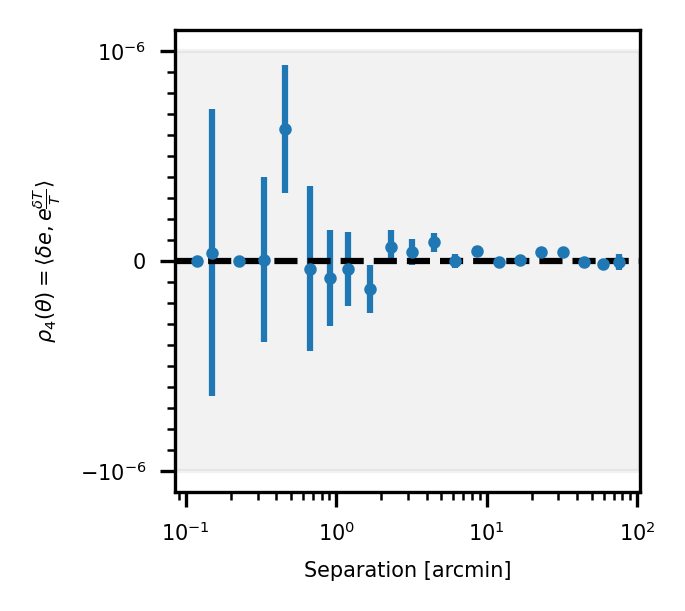

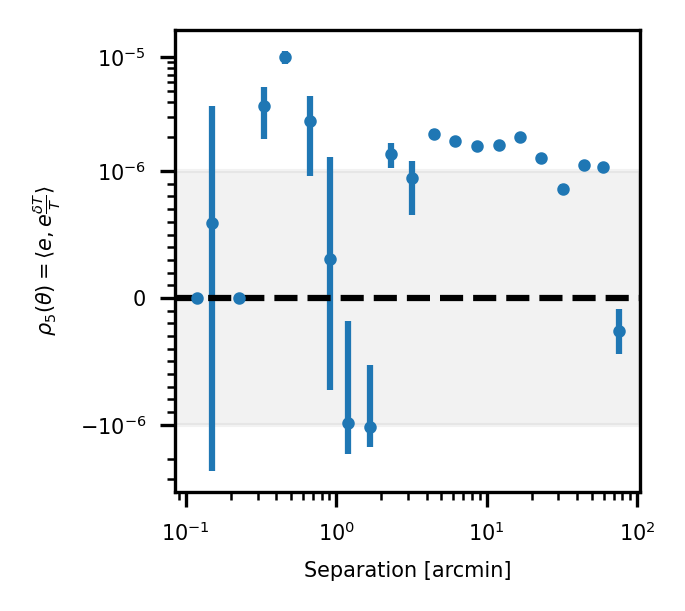

In [57]:
produceResults = atool.produce(processResults, band=f"{my_band}", skymap=skymap)

In [28]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

ModuleNotFoundError: No module named 'clmm'

In [23]:
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

1970
GCData
> defined by: cosmo='CCLCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)', bin_units='Mpc'
> with columns: radius_min, radius, radius_max, gt, gt_err, gx, gx_err, z, z_err, n_src, W_l
> 7 objects
    radius_min            radius           radius_max     ... z_err n_src  W_l 
------------------ ------------------- ------------------ ... ----- ----- -----
               0.4 0.47311105657229646 0.6020559536432087 ...   0.0     4   4.0
0.6020559536432087  0.7631067546508187 0.9061784282930837 ...   0.0    13  13.0
0.9061784282930837  1.1532199063756983 1.3639252945422413 ...   0.0    34  34.0
1.3639252945422413  1.7141000939501352  2.052898359759309 ...   0.0    63  63.0
 2.052898359759309   2.609271283124659  3.089899199293674 ...   0.0   173 173.0
 3.089899199293674  3.9179922196459764  4.650730522730349 ...   0.0   343 343.0
 4.650730522730349   5.860731511979476                7.0 ...   0.0   762 762.0
1970
GCData
> defined by: cosmo='CCLCosmology(H0=70.0, 

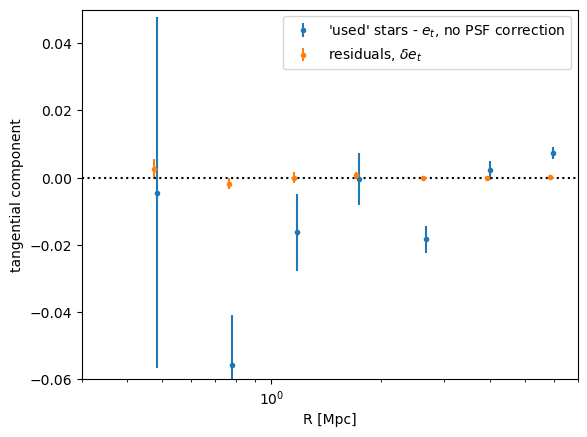

In [24]:
galcat = GCData()
galcat['ra'] = merged_cat_used['coord_ra']
galcat['dec'] = merged_cat_used['coord_dec']
galcat['e1'] = e1_star_used - e1_psf_used
galcat['e2'] = e2_star_used - e2_psf_used
#galcat['e_err'] = e_err[to_use]/2.  # factor 2 to account for conversion between e and g

galcat['z'] = np.zeros(len(galcat['ra'])) # CLMM needs a redshift column for the source, even if not used

cluster_id = "Abell 360"
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, 
                                coordinate_system='euclidean')


gc_object1.compute_tangential_and_cross_components(add=True);

print(len(gc_object1.galcat))

bins_mpc = clmm.make_bins(0.4,7,nbins=7, method='evenlog10width')
gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, 
                               use_weights=False, error_model='ste');

print(gc_object1.profile)

galcat = GCData()
galcat['ra'] = merged_cat_used['coord_ra']
galcat['dec'] = merged_cat_used['coord_dec']
galcat['e1'] = e1_star_used# - e1_psf_used
galcat['e2'] = e2_star_used# - e2_psf_used
#galcat['e_err'] = e_err[to_use]/2.  # factor 2 to account for conversion between e and g
galcat['z'] = np.zeros(len(galcat['ra'])) # CLMM needs a redshift column for the source, even if not used

gc_object2 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, 
                                coordinate_system='euclidean')


gc_object2.compute_tangential_and_cross_components(add=True);

print(len(gc_object2.galcat))

bins_mpc = clmm.make_bins(0.4,7,nbins=7, method='evenlog10width')
gc_object2.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, 
                               use_weights=False, error_model='ste');

print(gc_object2.profile)


plt.errorbar(gc_object2.profile['radius']*1.02, gc_object2.profile['gt'], gc_object2.profile['gt_err'], 
             ls='', marker='.', label=r"'used' stars - $e_t$, no PSF correction")
plt.errorbar(gc_object1.profile['radius'], gc_object1.profile['gt'], gc_object1.profile['gt_err'], 
             ls='', marker='.', label=r'residuals, $\delta e_t$')

plt.xscale('log')
plt.axhline(0.0, color='k', ls=':')
#plt.ylim([-0.01,0.01])
plt.ylim([-0.06,0.05])
plt.xlim([0.3,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('tangential component')
plt.legend(loc=1)
plt.savefig(f"profile_{version}.png")

234
GCData
> defined by: cosmo='CCLCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)', bin_units='Mpc'
> with columns: radius_min, radius, radius_max, gt, gt_err, gx, gx_err, z, z_err, n_src, W_l
> 6 objects
    radius_min           radius           radius_max     ... z_err n_src W_l 
------------------ ------------------ ------------------ ... ----- ----- ----
0.6020559536432087 0.7501378000024584 0.9061784282930837 ...   0.0     4  4.0
0.9061784282930837 1.0841084070595162 1.3639252945422413 ...   0.0     3  3.0
1.3639252945422413 1.8424638862251181  2.052898359759309 ...   0.0     7  7.0
 2.052898359759309 2.6379568366665285  3.089899199293674 ...   0.0    20 20.0
 3.089899199293674 3.9044335632370433  4.650730522730349 ...   0.0    46 46.0
 4.650730522730349  5.794507843028761                7.0 ...   0.0    88 88.0
234
GCData
> defined by: cosmo='CCLCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)', bin_units='Mpc'
> with columns: radius_min, radiu

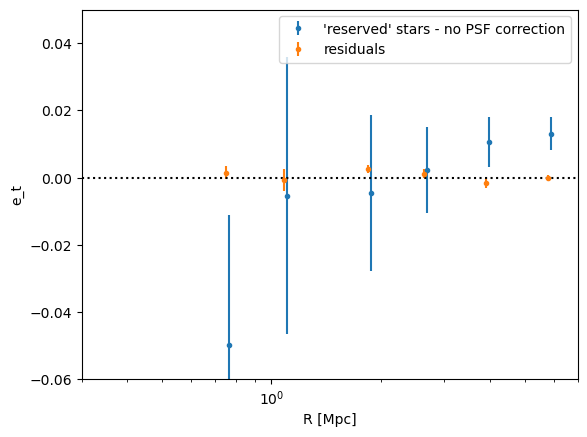

In [25]:
galcat = GCData()
galcat['ra'] = merged_cat_reserved['coord_ra']
galcat['dec'] = merged_cat_reserved['coord_dec']
galcat['e1'] = e1_star_reserved - e1_psf_reserved
galcat['e2'] = e2_star_reserved - e2_psf_reserved
#galcat['e_err'] = e_err[to_use]/2.  # factor 2 to account for conversion between e and g

galcat['z'] = np.zeros(len(galcat['ra'])) # CLMM needs a redshift column for the source, even if not used

cluster_id = "Abell 360"
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, 
                                coordinate_system='euclidean')


gc_object1.compute_tangential_and_cross_components(add=True);

print(len(gc_object1.galcat))

bins_mpc = clmm.make_bins(0.4,7,nbins=7, method='evenlog10width')
gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, 
                               use_weights=False, error_model='ste');

print(gc_object1.profile)

galcat = GCData()
galcat['ra'] = merged_cat_reserved['coord_ra']
galcat['dec'] = merged_cat_reserved['coord_dec']
galcat['e1'] = e1_star_reserved# - e1_psf_reserved
galcat['e2'] = e2_star_reserved# - e2_psf_reserved
#galcat['e_err'] = e_err[to_use]/2.  # factor 2 to account for conversion between e and g
galcat['z'] = np.zeros(len(galcat['ra'])) # CLMM needs a redshift column for the source, even if not used

gc_object2 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, 
                                coordinate_system='euclidean')


gc_object2.compute_tangential_and_cross_components(add=True);

print(len(gc_object2.galcat))

bins_mpc = clmm.make_bins(0.4,7,nbins=7, method='evenlog10width')
gc_object2.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, 
                               use_weights=False, error_model='ste');

print(gc_object2.profile)


plt.errorbar(gc_object2.profile['radius']*1.02, gc_object2.profile['gt'], gc_object2.profile['gt_err'], 
             ls='', marker='.', label="'reserved' stars - no PSF correction")
plt.errorbar(gc_object1.profile['radius'], gc_object1.profile['gt'], gc_object1.profile['gt_err'], 
             ls='', marker='.', label='residuals')

plt.xscale('log')
plt.axhline(0.0, color='k', ls=':')
#plt.ylim([-0.01,0.01])
plt.ylim([-0.06,0.05])
plt.xlim([0.3,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('e_t')
plt.legend(loc=1)
plt.savefig(f"profile_{version}.png")

234
GCData
> defined by: cosmo='CCLCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)', bin_units='Mpc'
> with columns: radius_min, radius, radius_max, gt, gt_err, gx, gx_err, z, z_err, n_src, W_l
> 6 objects
    radius_min           radius           radius_max     ... z_err n_src W_l 
------------------ ------------------ ------------------ ... ----- ----- ----
0.6020559536432087 0.7501378000024584 0.9061784282930837 ...   0.0     4  4.0
0.9061784282930837 1.0841084070595162 1.3639252945422413 ...   0.0     3  3.0
1.3639252945422413 1.8424638862251181  2.052898359759309 ...   0.0     7  7.0
 2.052898359759309 2.6379568366665285  3.089899199293674 ...   0.0    20 20.0
 3.089899199293674 3.9044335632370433  4.650730522730349 ...   0.0    46 46.0
 4.650730522730349  5.794507843028761                7.0 ...   0.0    88 88.0
1970
GCData
> defined by: cosmo='CCLCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)', bin_units='Mpc'
> with columns: radius_min, radi

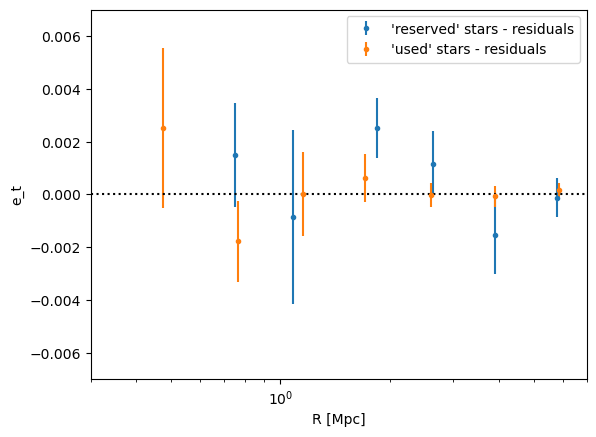

In [26]:
galcat = GCData()
galcat['ra'] = merged_cat_reserved['coord_ra']
galcat['dec'] = merged_cat_reserved['coord_dec']
galcat['e1'] = e1_star_reserved - e1_psf_reserved
galcat['e2'] = e2_star_reserved - e2_psf_reserved
#galcat['e_err'] = e_err[to_use]/2.  # factor 2 to account for conversion between e and g

galcat['z'] = np.zeros(len(galcat['ra'])) # CLMM needs a redshift column for the source, even if not used

cluster_id = "Abell 360"
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, 
                                coordinate_system='euclidean')


gc_object1.compute_tangential_and_cross_components(add=True);

print(len(gc_object1.galcat))

bins_mpc = clmm.make_bins(0.4,7,nbins=7, method='evenlog10width')
gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, 
                               use_weights=False, error_model='ste');

print(gc_object1.profile)



galcat = GCData()
galcat['ra'] = merged_cat_used['coord_ra']
galcat['dec'] = merged_cat_used['coord_dec']
galcat['e1'] = e1_star_used - e1_psf_used
galcat['e2'] = e2_star_used - e2_psf_used
#galcat['e_err'] = e_err[to_use]/2.  # factor 2 to account for conversion between e and g
galcat['z'] = np.zeros(len(galcat['ra'])) # CLMM needs a redshift column for the source, even if not used

gc_object2 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, 
                                coordinate_system='euclidean')


gc_object2.compute_tangential_and_cross_components(add=True);

print(len(gc_object2.galcat))

gc_object2.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, 
                               use_weights=False, error_model='ste');

print(gc_object2.profile)


plt.errorbar(gc_object1.profile['radius'], gc_object1.profile['gt'], gc_object1.profile['gt_err'], 
             ls='', marker='.', label="'reserved' stars - residuals")
plt.errorbar(gc_object2.profile['radius'], gc_object2.profile['gt'], gc_object2.profile['gt_err'], 
             ls='', marker='.', label="'used' stars - residuals")

plt.xscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.007,0.007])
#plt.ylim([-0.06,0.05])
plt.xlim([0.3,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('e_t')
plt.legend(loc=1)
plt.savefig(f"profile_{version}.png")

In [27]:
e1_psf_all, e2_psf_all = get_psf_ellip(merged_cat_all)
e_psf_all = np.sqrt(e1_psf_all*e1_psf_all + e2_psf_all*e2_psf_all) # module of ellipticity
theta_psf_all = 0.5 * np.arctan(e2_psf_all/e1_psf_all) # orientation

cx_psf_all = e_psf_all * np.cos(theta_psf_all) # x-component of the vector for the whisker plot
cy_psf_all = e_psf_all * np.sin(theta_psf_all) # y-component of the vector for the whisker plot

# `all` stars
e1_star_all, e2_star_all = get_star_ellip(merged_cat_all)
e_star_all = np.sqrt(e1_star_all*e1_star_all + e2_star_all*e2_star_all) # module of ellipticity
theta_star_all = 0.5 * np.arctan(e2_star_all/e1_star_all) # orientation

cx_star_all = e_star_all * np.cos(theta_star_all) # x-component of the vector for the whisker plot
cy_star_all = e_star_all * np.sin(theta_star_all) # y-component of the vector for the whisker plot

GCData
> defined by: cosmo='CCLCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)', bin_units='Mpc'
> with columns: radius_min, radius, radius_max, gt, gt_err, gx, gx_err, z, z_err, n_src, W_l
> 7 objects
    radius_min           radius           radius_max     ... z_err n_src   W_l  
------------------ ------------------ ------------------ ... ----- ----- -------
               0.4 0.5118222416158662 0.6020559536432087 ...   0.0   563   563.0
0.6020559536432087 0.7623651534322013 0.9061784282930837 ...   0.0  1233  1233.0
0.9061784282930837 1.1529408880990168 1.3639252945422413 ...   0.0  2941  2941.0
1.3639252945422413 1.7325255310588314  2.052898359759309 ...   0.0  6877  6877.0
 2.052898359759309 2.6026209518031616  3.089899199293674 ...   0.0 15631 15631.0
 3.089899199293674 3.9199536285936665  4.650730522730349 ...   0.0 33675 33675.0
 4.650730522730349 5.8766610719978605                7.0 ...   0.0 75670 75670.0


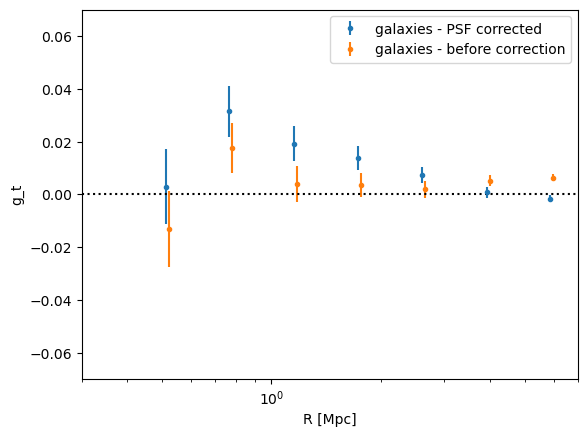

In [28]:
galcat = GCData()
galcat['ra'] = merged_cat_all['coord_ra']
galcat['dec'] = merged_cat_all['coord_dec']
galcat['e1'] = e1_star_all - e1_psf_all
galcat['e2'] = e2_star_all - e2_psf_all
#galcat['e_err'] = e_err[to_use]/2.  # factor 2 to account for conversion between e and g

galcat['z'] = np.zeros(len(galcat['ra'])) # CLMM needs a redshift column for the source, even if not used

cluster_id = "Abell 360"
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, 
                                coordinate_system='euclidean')

gc_object1.compute_tangential_and_cross_components(add=True);
gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, );


galcat = GCData()
galcat['ra'] = merged_cat_all['coord_ra']
galcat['dec'] = merged_cat_all['coord_dec']
galcat['e1'] = e1_star_all# - e1_psf_all
galcat['e2'] = e2_star_all# - e2_psf_all
#galcat['e_err'] = e_err[to_use]/2.  # factor 2 to account for conversion between e and g

galcat['z'] = np.zeros(len(galcat['ra'])) # CLMM needs a redshift column for the source, even if not used
cluster_id = "Abell 360"
gc_object2 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, 
                                coordinate_system='euclidean')

gc_object2.compute_tangential_and_cross_components(add=True);
gc_object2.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, );

print(gc_object2.profile)

plt.errorbar(gc_object1.profile['radius'], gc_object1.profile['gt'], gc_object1.profile['gt_err'], 
             ls='', marker='.', label='galaxies - PSF corrected')
plt.errorbar(gc_object2.profile['radius']*1.02, gc_object2.profile['gt'], gc_object2.profile['gt_err'], 
             ls='', marker='.', label='galaxies - before correction')

plt.xscale('log')
plt.axhline(0.0, color='k', ls=':')
#plt.ylim([-0.01,0.01])
plt.ylim([-0.07,0.07])
plt.xlim([0.3,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('g_t')
plt.legend(loc=1)
plt.savefig(f"profile_{version}.png")